WiDS2021

Author: PG


EXPLORATORY DATA ANALYSIS + BUILDING MODELS

* 1) Reading the csv file training set as df
* 2) Check if target (diabetes_mellitus) is unbalanced
* 3) Check if there are missing values
* 4) Check the variables that are highly correlated with the target one
* 5) Correlation map to see if there are variables that are highly correlated with the others, to avoid multicollinearity. 
* 6) Remove columns where missing values are more than 80% of the entire column, columns that have low correlation with target variable. Remove Readmission because it has only zeros and other column ids that I don't think are relevant to the analysis. Remove columns that are visible correlated with other ones to avoid multicollinearity.
* 7) Drop BMI column because it can be derived from weight and height, I want to avoid multicollinearity. Before dropping it I assess that BMI can't be used to derive missing height or missing weight values.
* 8) Use MICE to replace missing values in numerical columns
* 9) Use SingleImputer to replace missing values in categorical variables, strategy "most frequent"
* 10) Use one hot encoding to transform categorical columns into numerical ones.
* 11) Apply all the pre-processing steps (up to point 11)  for the unlabel test data (df_unlabel).
* 12) Align dataset df with unlabel test data to make sure they have the same columns. 
* 13) Split our df dataset into X and y datasets.
* 14) Performing Random Undersampling and then Oversampling to rebalance the dataset
* 15) Apply PCA to perform feature selection on standardized X dataset. 
* 16) Creation of Logistic Regression Models and creation of classification reports to compare different types of logistic regressions 
* 17) Creation of Random Forest Classifier on rebalanced dataset and creation of classification report
* 18) Creation of a xgboost model on rebalanced dataset and creation of classification report
* 19) Application of GridSearch to improve parameters for xgboost model creation
* 20) Creation of a deep learning model with Tensoflow to try to improve the results


In [88]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from fancyimpute import IterativeImputer as MICE
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout


In [8]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [9]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/widsdatathon2021/SampleSubmissionWiDS2021.csv
/kaggle/input/widsdatathon2021/SolutionTemplateWiDS2021.csv
/kaggle/input/widsdatathon2021/DataDictionaryWiDS2021.csv
/kaggle/input/widsdatathon2021/UnlabeledWiDS2021.csv
/kaggle/input/widsdatathon2021/TrainingWiDS2021.csv


# 1) Reading the csv file training set as df, df_unlabel and show its information

In [10]:
df = pd.read_csv('../input/widsdatathon2021/TrainingWiDS2021.csv')
df_raw = df.copy()
df_unlabel = pd.read_csv('../input/widsdatathon2021/UnlabeledWiDS2021.csv')
unlabel_raw = df_unlabel.copy() 

In [11]:
print('Shape of data training : {}'.format(df.shape)) 
print('Shape of data unlabel (test): {}'.format(df_unlabel.shape)) 
df.info()
df.describe()
np.shape(df)
df.head()

Shape of data training : (130157, 181)
Shape of data unlabel (test): (10234, 180)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130157 entries, 0 to 130156
Columns: 181 entries, Unnamed: 0 to diabetes_mellitus
dtypes: float64(157), int64(18), object(6)
memory usage: 179.7+ MB


,Unnamed: 0,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_albumin_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus
0,1,214826,118,68.0,22.732803,0,Caucasian,M,180.3,Floor,Floor,92,admit,CTICU,0.541667,0,73.9,2.3,113.0,502.01,0,0,0.4,31.0,2.51,NaN,3.0,6.0,0.0,4.0,168.0,118.0,27.4,0,40.0,NaN,NaN,NaN,NaN,36.0,134.0,39.3,NaN,0,14.1,46.0,32.0,68.0,37.0,68.0,37.0,119.0,72.0,66.0,40.0,89.0,46.0,89.0,46.0,34.0,10.0,100.0,74.0,122.0,64.0,131.0,73.0,131.0,73.0,39.9,37.2,NaN,NaN,68.0,63.0,68.0,63.0,119.0,108.0,NaN,NaN,86.0,85.0,86.0,85.0,26.0,18.0,100.0,74.0,NaN,NaN,131.0,115.0,131.0,115.0,39.5,37.5,2.3,2.3,0.4,0.4,31.0,30.0,8.5,7.4,2.51,2.23,168.0,109.0,19.0,15.0,8.9,8.9,27.4,27.4,NaN,NaN,1.3,1.0,233.0,233.0,4.0,3.4,136.0,134.0,14.1,14.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,1
1,2,246060,81,77.0,27.421875,0,Caucasian,F,160.0,Floor,Floor,90,admit,Med-Surg ICU,0.927778,0,70.2,NaN,108.0,203.01,0,0,NaN,9.0,0.56,1.0,1.0,3.0,0.0,1.0,145.0,120.0,36.9,0,46.0,37.0,37.0,51.0,7.45,33.0,145.0,35.1,NaN,1,12.7,NaN,NaN,95.0,31.0,95.0,31.0,118.0,72.0,NaN,NaN,1

# 2) Check if target (diabetes_mellitus) is unbalanced

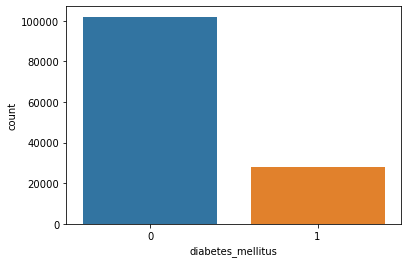

In [12]:
sns.countplot(x='diabetes_mellitus',data=df)

In [13]:
(df['diabetes_mellitus'].value_counts()/df['diabetes_mellitus'].count())*100

0    78.371505
1    21.628495
Name: diabetes_mellitus, dtype: float64

we can see that the training set is highly unbalanced, around 22 percentage is diabetes versus 78 non diabetes


# 3) Check if there are missing values

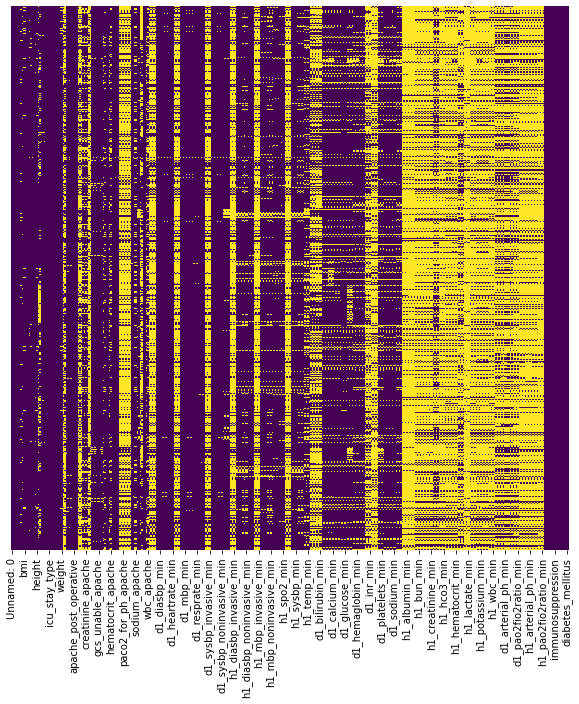

In [14]:
plt.figure(figsize=(10,10))
sns.heatmap(df.isnull(), yticklabels=False,cbar=False,cmap='viridis')

yellow is where there are missing values, we can see that some columns have a lot of missing values. 

Check missing values and columns where there are more than 80% missing values

In [15]:
Missing_valuestable = pd.DataFrame(df.isnull().mean() * 100)
Missing_valuestable.columns={'Missing_perc'}
Mv =Missing_valuestable[Missing_valuestable['Missing_perc']>80]
Mv = Mv.reset_index()

Listcolumn_manymissings = Mv['index'].to_list()
Mv

,index,Missing_perc
0,h1_diasbp_invasive_max,80.540424
1,h1_diasbp_invasive_min,80.540424
2,h1_mbp_invasive_max,80.492021
3,h1_mbp_invasive_min,80.492021
4,h1_sysbp_invasive_max,80.523522
5,h1_sysbp_invasive_min,80.523522
6,h1_albumin_max,91.431886
7,h1_albumin_min,91.431886
8,h1_bilirubin_max,92.089553
9,h1_bilirubin_min,92.089553


# 4) Check the variables that are highly correlated with the target one and the ones that have a low correlation with the target variable, in absolute value.

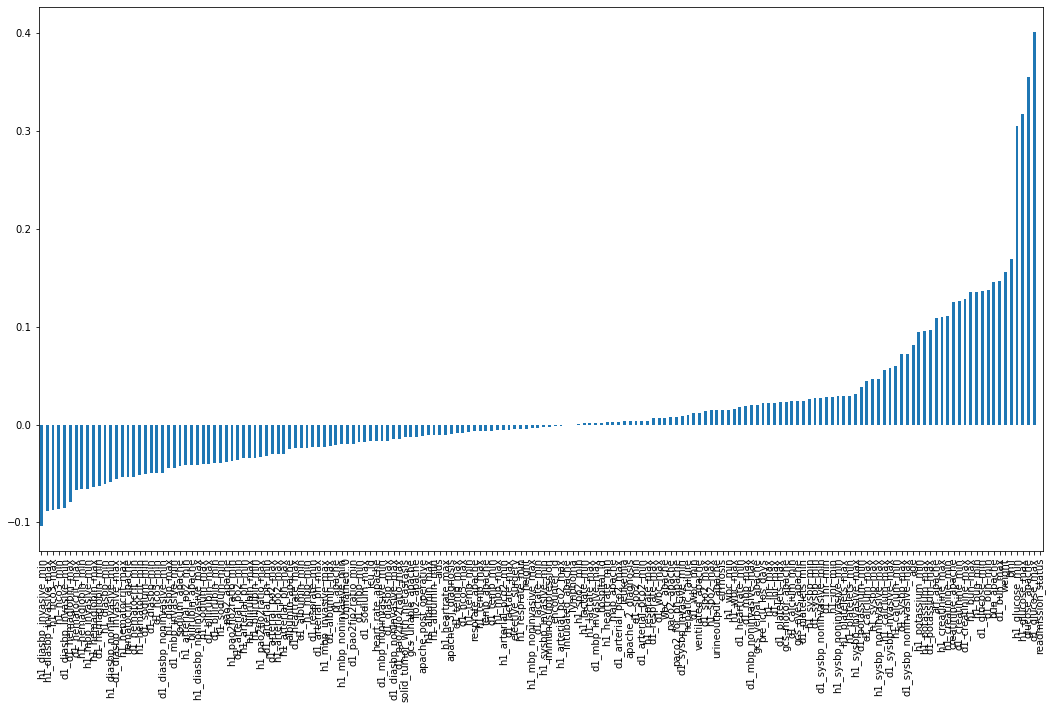

In [16]:
plt.figure(figsize=(18,10))
df.corr()['diabetes_mellitus'][:-1].sort_values().plot(kind='bar')
Mcorr = pd.DataFrame(df.corr()['diabetes_mellitus'][:-1].sort_values().abs())

Mcorr = Mcorr.reset_index()
Mcorr=Mcorr[Mcorr['diabetes_mellitus']<0.05]
Listcolumn_low_corr = Mcorr['index'].tolist()



# 5) Correlation map to see if there are variables that are highly correlated with the others, to avoid multicollinearity

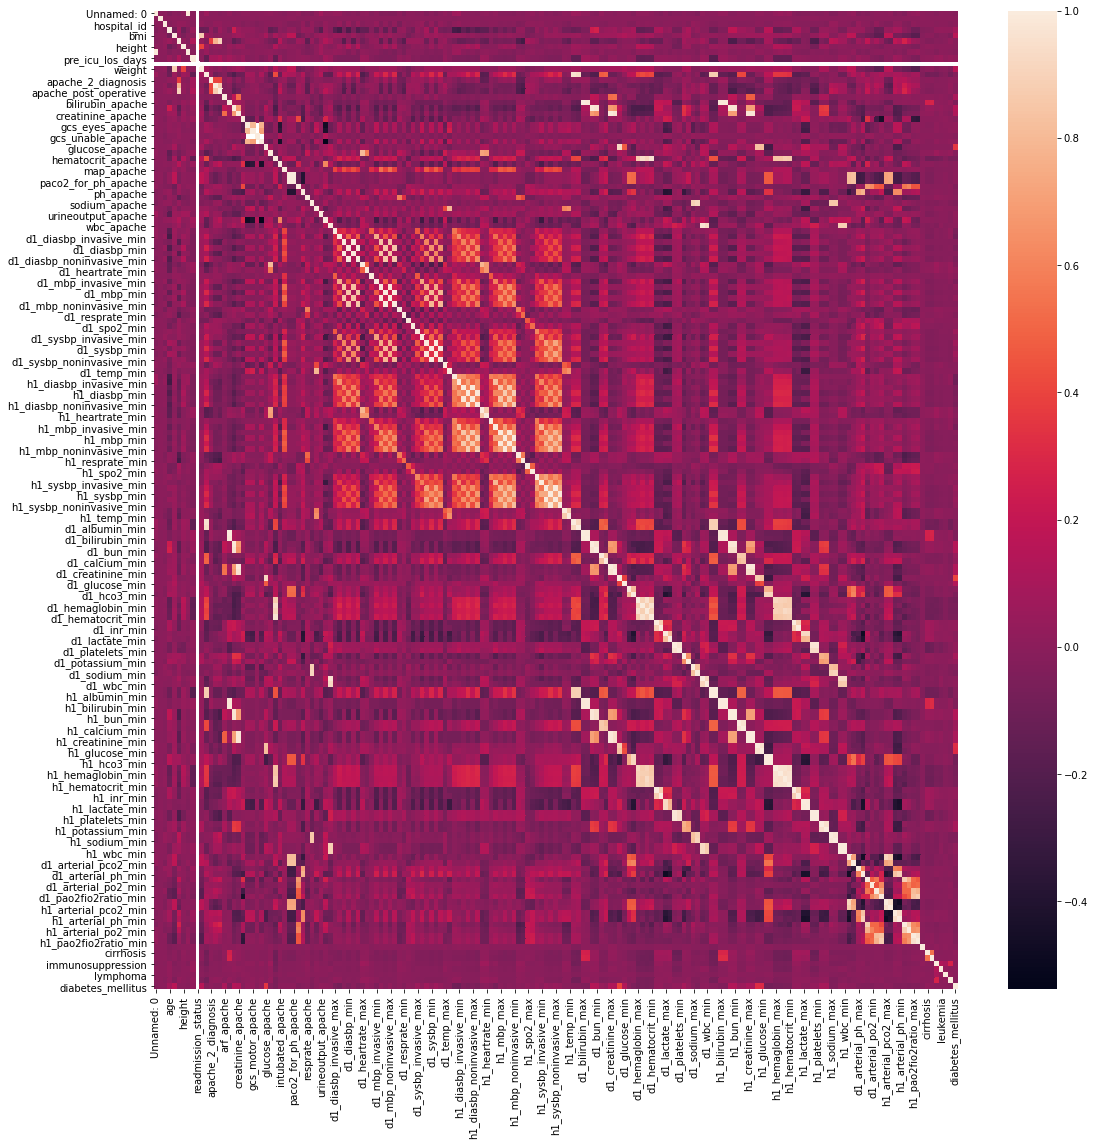

In [17]:
plt.figure(figsize=(18,18))
sns.heatmap(df.corr())

we can see that there are columns that are highly correlated among themselves, we should consider dropping one of them to avoid multicollinearity

we can see that readmission status is a white line, if we explore this column we discover that it has all zeros, it is not informative and we can drop it.

In [18]:
df['readmission_status'].value_counts()

0    130157
Name: readmission_status, dtype: int64

# 6) Remove columns where missing values are more than 80% of the entire column and remove columns that have low correlation with target variable. Remove Readmission because it only  has zeros and other column ids that I don't think are relevant to the analysis. Remove columns that are correlated with other ones to avoid multicollinearity

In [19]:
Listcolumn_to_delete =Listcolumn_manymissings +Listcolumn_low_corr
Listcolumn_to_delete = set(Listcolumn_to_delete)

In [20]:
df.drop(Listcolumn_to_delete, axis=1, inplace=True)

In [21]:
df.drop(['readmission_status' ], axis=1, inplace= True)

there is no need to drop these specific columns 'Unnamed: 0','encounter_id', 'hospital_id' because they are already inside the listcolumn_to_delete.

In [22]:
np.shape(df)

(130157, 42)

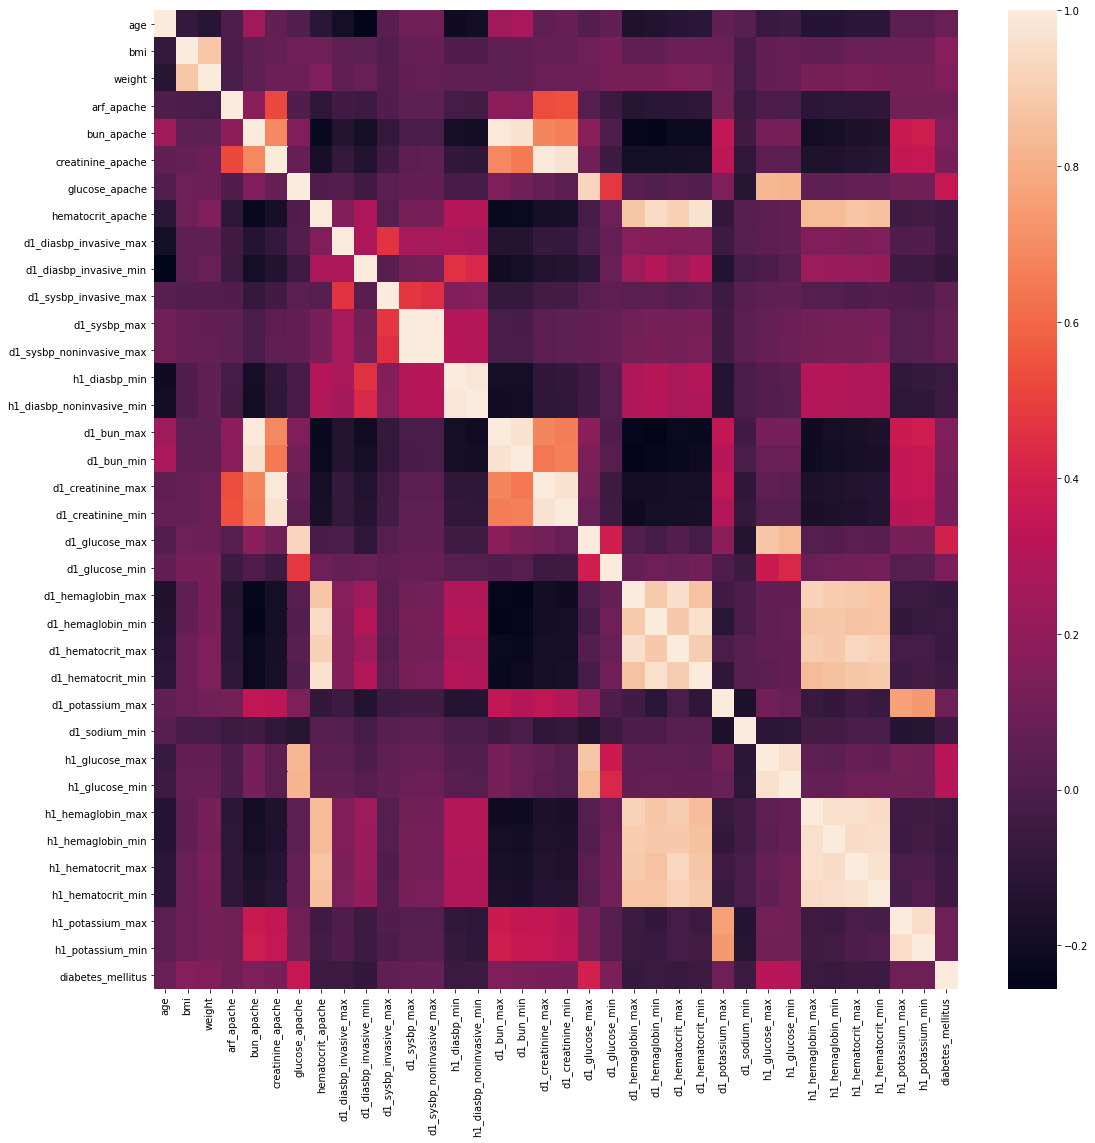

In [23]:
plt.figure(figsize=(18,18))
sns.heatmap(df.corr())

we want to drop columns that are highly correlated among themselves, to avoid multicollinearity:

In [24]:
df.drop(['h1_hemaglobin_max','h1_hemaglobin_min','h1_hematocrit_max', 'd1_hemaglobin_max','d1_hemaglobin_min','d1_hematocrit_max','h1_glucose_max','d1_sysbp_max','d1_bun_max', 'd1_creatinine_max','h1_diasbp_min' ,'h1_potassium_min'], axis=1, inplace= True)

# 7) Drop BMI column because it can be derived from weight and height, I want to avoid multicollinearity. Before dropping it I assess that BMI can't be used to derive missing height or missing weight values

In [25]:
df_raw[df_raw['height'].isnull() & df_raw['weight'].notnull() & df_raw['bmi'].notnull()]

,Unnamed: 0,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_albumin_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus


height can't be derived from weight and bmi because if height is missing the other two variables are missing as well.

In [26]:
df_raw[df_raw['height'].notnull() & df_raw['weight'].isnull() & df_raw['bmi'].notnull()]

,Unnamed: 0,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_albumin_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus


weight can't be derived from height and bmi becuase if weight is missing the other variables are missing as well. 

bmi is derived from the formulas kg/m2, having height and weight we should remove it from the columns to avoid multicollinearity

In [27]:
df.drop(['bmi'], axis=1, inplace= True)

# 8) Use MICE to replace missing values in numerical columns

Creating df table with only numerical columns, we will use this table to apply MICE and input missing values. 

In [28]:
df_numericalcolumns= df._get_numeric_data()
df_numericalcolumns= df_numericalcolumns.drop(['diabetes_mellitus'], axis=1)

In [29]:
df_numericalcolumns.iloc[:, :]  = MICE().fit_transform(df_numericalcolumns)

/opt/conda/lib/python3.7/site-packages/sklearn/impute/_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


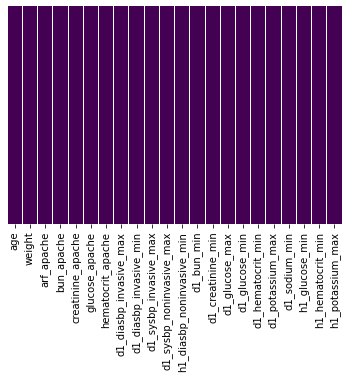

In [30]:
sns.heatmap(df_numericalcolumns.isnull(), yticklabels=False,cbar=False,cmap='viridis')

we can see that the table df_numericalcolumns doesnt contain missing values (no yellow lines)

# 9) Use SingleImputer to replace missing values in categorical variables, strategy "most frequent", replace missing values in ethnicity with pre-existent category Other/Unknown

In [31]:
 df['ethnicity'].fillna('Other/Unknown', inplace=True)

creating table with only categorical variables:

In [32]:
cols = df.columns
num_cols = df._get_numeric_data().columns
list_categoricalcolumns= list(set(cols) - set(num_cols))
df_categoricalcolumns= df[list_categoricalcolumns]
df_categoricalcolumns.head()

,icu_type,gender,hospital_admit_source,icu_stay_type,ethnicity,icu_admit_source
0,CTICU,M,Floor,admit,Caucasian,Floor
1,Med-Surg ICU,F,Floor,admit,Caucasian,Floor
2,Med-Surg ICU,F,Emergency Department,admit,Caucasian,Accident & Emergency
3,CTICU,F,Operating Room,admit,Caucasian,Operating Room / Recovery
4,Med-Surg ICU,M,NaN,admit,Caucasian,Accident & Emergency


In [33]:
t = df.groupby(['icu_admit_source', 'hospital_admit_source']).sum().reset_index()[['icu_admit_source', 'hospital_admit_source']]
t

,icu_admit_source,hospital_admit_source
0,Accident & Emergency,Acute Care/Floor
1,Accident & Emergency,Chest Pain Center
2,Accident & Emergency,Direct Admit
3,Accident & Emergency,Emergency Department
4,Accident & Emergency,Floor
5,Accident & Emergency,ICU
6,Accident & Emergency,ICU to SDU
7,Accident & Emergency,Observation
8,Accident & Emergency,Operating Room
9,Accident & Emergency,Other Hospital


we can clearly see that the category Floor is available in the two columns "icu_admit_source" and "hospital_admit_source" and this can clearly create issues in the one hot encoding process. We are going to rename the category floor in the Icu_admit_source

In [34]:
icu_admit_source_d = {'Accident & Emergency': 'Accident & Emergency','Floor': 'ICU_Floor', 'Other ICU': 'Other ICU', 'Operating Room / Recovery': 'Operating Room / Recovery', 'Other Hospital': 'Other Hospital'}

In [35]:
df['icu_admit_source']= df.icu_admit_source.map(icu_admit_source_d)

singleImputer:

In [36]:
imp = SimpleImputer(strategy="most_frequent")
df_categoricalcolumns.iloc[:, :]  =imp.fit_transform(df_categoricalcolumns)

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Rejoining numerical variables with categorical ones to recreate df without missing values:

In [37]:
df=pd.concat([df_numericalcolumns,df['diabetes_mellitus'],df_categoricalcolumns],axis=1)

In [38]:
np.shape(df)

(130157, 29)

# 10) Use one hot encoding to transform categorical columns into numerical ones. 

Create one hot encoding for the six categorical variables, dropping the first column created with one hot encoding. I just apply the hot encoding variables to the dataset with numerical columns in order to have our new df. 

In [39]:
for i in list_categoricalcolumns:
    i= pd.get_dummies(df[i],drop_first=True)
    i=pd.DataFrame(i)
    df_numericalcolumns=pd.concat([df_numericalcolumns,i],axis=1)

In df_numericalcolumns all the categorical ones have been converted with one hot encoding so all the column are numerical.

In [40]:
df = df_numericalcolumns

In [41]:
np.shape(df)

(130157, 55)

# 11) Apply all the pre-processing steps (up to point 11)  for the unlabel test data (df_unlabel).

In [42]:
df_unlabel.drop(Listcolumn_to_delete, axis=1, inplace=True)
df_unlabel.drop(['readmission_status'], axis=1, inplace= True)
df_unlabel.drop(['d1_hemaglobin_max','d1_hemaglobin_min','d1_hematocrit_max','h1_glucose_max','d1_sysbp_max','d1_bun_max', 'd1_creatinine_max','h1_diasbp_min' ], axis=1, inplace= True)
df_unlabel.drop(['bmi' ], axis=1, inplace= True)

MICE:

In [43]:
df_unlabel_numcolumns= df_unlabel._get_numeric_data()

In [44]:
df_unlabel_numcolumns.iloc[:, :]  = MICE().fit_transform(df_unlabel_numcolumns)

/opt/conda/lib/python3.7/site-packages/sklearn/impute/_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


SingleImputer:

In [45]:
 df_unlabel['ethnicity'].fillna('Other/Unknown', inplace=True)

In [46]:
df_unlabel['icu_admit_source']= df_unlabel.icu_admit_source.map(icu_admit_source_d)

In [47]:
df_unlabel_categoricalcolumns= df_unlabel[list_categoricalcolumns]
df_unlabel_categoricalcolumns.iloc[:, :]  =imp.fit_transform(df_unlabel_categoricalcolumns)

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Recreating the dataset with no missing values:

In [48]:
df_unlabel=pd.concat([df_unlabel_numcolumns,df_unlabel_categoricalcolumns],axis=1)

One hot encoding:

In [49]:
for i in list_categoricalcolumns:
    i= pd.get_dummies(df_unlabel[i],drop_first=True)
    i=pd.DataFrame(i)
    df_unlabel_numcolumns=pd.concat([df_unlabel_numcolumns,i],axis=1)

In [50]:
df_unlabel=df_unlabel_numcolumns

# 12) Align the dataset df with unlabel test data to make sure they have the same columns creating f_df and f_df_unlabel

In [51]:
f_df, f_df_unlabel = df.align(df_unlabel, join='inner', axis=1)
f_df['diabetes_mellitus']=df_raw['diabetes_mellitus']

remove duplicated columns, just to be sure: 

In [52]:
f_df = f_df.loc[:,~f_df.columns.duplicated()]
f_df_unlabel = f_df_unlabel.loc[:,~f_df_unlabel.columns.duplicated()]

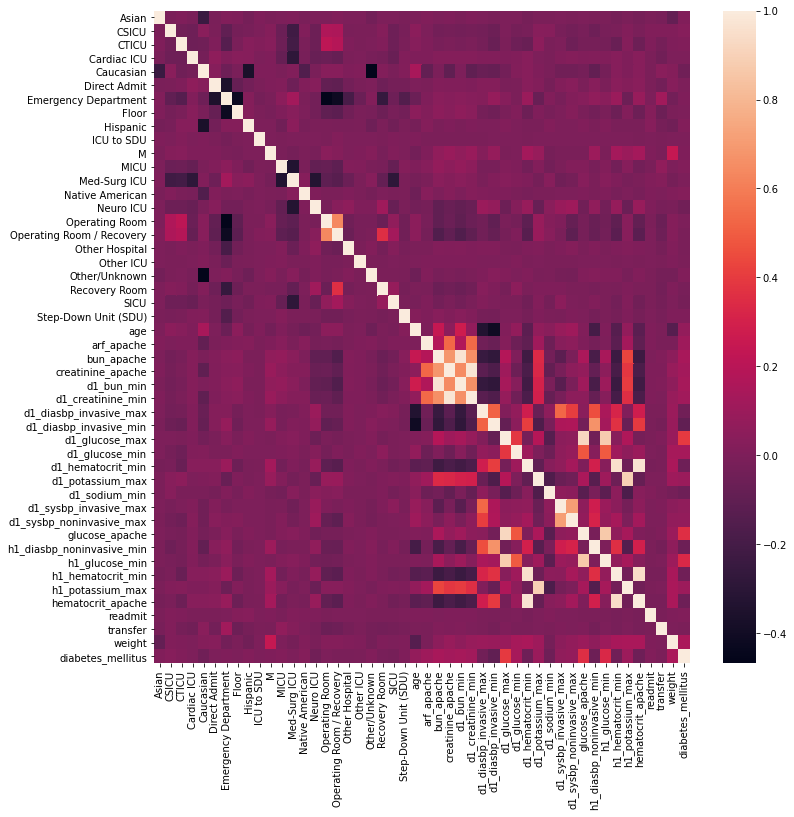

In [53]:
plt.figure(figsize=(12,12))
sns.heatmap(f_df.corr())

# 13) Split our f_df dataset into X and y datasets.

In [54]:
X = np.array(f_df.iloc[:, f_df.columns != 'diabetes_mellitus'])
y = np.array(f_df.iloc[:, f_df.columns == 'diabetes_mellitus'])
print('Shape of X: {}'.format(X.shape))
print('Shape of y: {}'.format(y.shape))

Shape of X: (130157, 47)
Shape of y: (130157, 1)


In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, shuffle=True)

print("X_train dataset: ", X_train.shape)
print("y_train dataset: ", y_train.shape)
print("X_test dataset: ", X_test.shape)
print("y_test dataset: ", y_test.shape)

X_train dataset:  (91109, 47)
y_train dataset:  (91109, 1)
X_test dataset:  (39048, 47)
y_test dataset:  (39048, 1)


# 14) Performing Random Undersampling and then Oversampling to rebalance the dataset

Undersampling strategy:

In [56]:
under = RandomUnderSampler(sampling_strategy=0.5)
X_train_under, y_train_under = under.fit_resample(X_train, y_train)

Oversampling strategy:

In [57]:
over = RandomOverSampler(sampling_strategy='minority')
X_train_res, y_train_res = over.fit_resample(X_train_under, y_train_under)

In [58]:
print("Raw Dataset, counts of label '1': {}".format(sum(y_train==1)))
print("Raw Dataset, counts of label '0': {} \n".format(sum(y_train==0)))
print("After UnderSampling, counts of label '1': {}".format(sum(y_train_under==1)))
print("After UnderSampling, counts of label '0': {} \n".format(sum(y_train_under==0)))
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {} \n".format(sum(y_train_res==0)))

Raw Dataset, counts of label '1': [19691]
Raw Dataset, counts of label '0': [71418] 

After UnderSampling, counts of label '1': 19691
After UnderSampling, counts of label '0': 39382 

After OverSampling, counts of label '1': 39382
After OverSampling, counts of label '0': 39382 



# 15) Apply PCA to perform feature selection on standardized X dataset 

In [59]:
std = StandardScaler()
X_train_std = std.fit_transform(X_train_res)
X_test_std = std.transform(X_test)

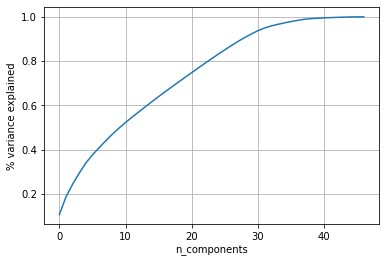

In [60]:
pca = PCA(n_components = X_train_std.shape[1])
pca_data = pca.fit_transform(X_train_std)

percent_var_explained = pca.explained_variance_/(np.sum(pca.explained_variance_))
cumm_var_explained = np.cumsum(percent_var_explained)

plt.plot(cumm_var_explained)
plt.grid()
plt.xlabel("n_components")
plt.ylabel("% variance explained")
plt.show()

I will keep the first 30 components that are explaining more than 90% of the variance

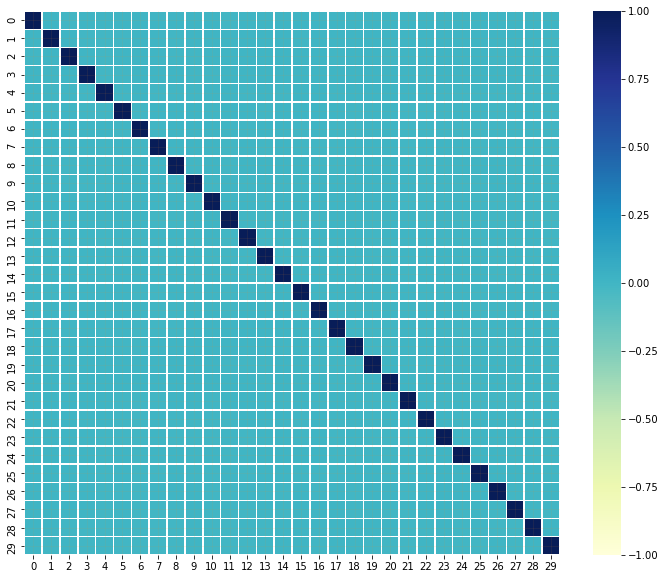

In [61]:
cumm_var_explained
pca = PCA(n_components=30)
pca_train_data = pca.fit_transform(X_train_std)

df_train_pca = pd.DataFrame(pca_train_data)

corr = df_train_pca.corr()
plt.figure(figsize = (12,10))

sns.heatmap(corr, annot = False, vmin=-1, vmax=1, cmap="YlGnBu", linewidths=.5)
plt.grid(b=True, color='#f68c1f', alpha=0.1)
plt.show()


Apply the PCA to test set:

In [62]:
pca_test_data = pca.transform(X_test_std)
df_test_pca = pd.DataFrame(pca_test_data)

Apply the PCA to unlabel standardised dataset:

In [63]:
f_df_unlabel_std = std.transform(f_df_unlabel)
pca_unlabel_data = pca.transform(f_df_unlabel_std)

f_df_unlabel_pca = pd.DataFrame(pca_unlabel_data)

X_train_std =pd.DataFrame(X_train_std)
X_test_std =pd.DataFrame(X_test_std)

# 16) Perform Logistic Regressions and creation of classification report to compare different types of logistic regressions 

Simple logistic regression without Rebalanced Dataset and without PCA:

In [64]:
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)
predictions_log = logmodel.predict(X_test)
print(classification_report(y_test,predictions_log))

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


              precision    recall  f1-score   support

           0       0.82      0.96      0.88     30588
           1       0.61      0.25      0.35      8460

    accuracy                           0.80     39048
   macro avg       0.72      0.60      0.62     39048
weighted avg       0.78      0.80      0.77     39048



/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


we can see that the recall for the minority variable is very low (0.25) 

Logistic Regression with Rebalanced Dataset and without PCA: 

In [66]:
logmodel_rebalanced = LogisticRegression(C = 0.0001)
logmodel_rebalanced.fit(X_train_res,y_train_res)
predictions_logreb = logmodel_rebalanced.predict(X_test)
print(classification_report(y_test,predictions_logreb))

              precision    recall  f1-score   support

           0       0.90      0.77      0.83     30588
           1       0.46      0.70      0.55      8460

    accuracy                           0.76     39048
   macro avg       0.68      0.74      0.69     39048
weighted avg       0.81      0.76      0.77     39048



/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [67]:
predictions_logreb = logmodel_rebalanced.predict(f_df_unlabel)

In [68]:
my_submission = pd.DataFrame({'encounter_id': pd.to_numeric(unlabel_raw['encounter_id']).astype(int), 'diabetes_mellitus': predictions_logreb})
# you could use any filename. We choose submission here
my_submission.to_csv('submission_rfc2.csv', index=False)

we can see that the recall of the minority variable improved a lot

Logistic Regression with  Rebalanced Dataset and PCA: 

In [70]:
logmodel_reb_pca = LogisticRegression()
logmodel_reb_pca.fit(df_train_pca,y_train_res)

predictions_logreb_pca = logmodel_reb_pca.predict(df_test_pca)
print(classification_report(y_test,predictions_logreb_pca))


              precision    recall  f1-score   support

           0       0.89      0.76      0.82     30588
           1       0.43      0.67      0.53      8460

    accuracy                           0.74     39048
   macro avg       0.66      0.71      0.67     39048
weighted avg       0.79      0.74      0.76     39048



we can see that the PCA is not improving our model, this is probably because we didnt have a lot of columns so the feature selection was not required. 

Normalization for the inputs is mainly used in linear models/knn/neural networks and it is not required in Logistic Regressions, Random Forest Classifier and XGBoost because they're not affected by absolute values taken by features.

# 17) Creation of Random Forest Classifier on  Rebalanced Dataset and creation of a classification report

Simple Random Forest without  Rebalanced Dataset and without PCA:

In [71]:
rfc = RandomForestClassifier(n_estimators=100)

rfc.fit(X_train,y_train)

predictions_rfc = rfc.predict(X_test)

print(classification_report(y_test,predictions_rfc))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


              precision    recall  f1-score   support

           0       0.84      0.94      0.89     30588
           1       0.63      0.36      0.46      8460

    accuracy                           0.82     39048
   macro avg       0.74      0.65      0.67     39048
weighted avg       0.80      0.82      0.80     39048



we see a low recall for minority class

Random Forest with  Rebalanced Dataset and without PCA:

In [72]:
rfc_reb = RandomForestClassifier(n_estimators=100)
rfc_reb.fit(X_train_res, y_train_res)
predictions_rfc_reb= rfc_reb.predict(X_test)
print(classification_report(y_test,predictions_rfc_reb))

              precision    recall  f1-score   support

           0       0.89      0.84      0.86     30588
           1       0.52      0.64      0.58      8460

    accuracy                           0.79     39048
   macro avg       0.71      0.74      0.72     39048
weighted avg       0.81      0.79      0.80     39048



In [ ]:
predictions_rfc_reb = rfc_reb.predict(f_df_unlabel)
my_submission = pd.DataFrame({'encounter_id': pd.to_numeric(unlabel_raw['encounter_id']).astype(int), 'diabetes_mellitus': predictions_rfc_reb})
# you could use any filename. We choose submission here
my_submission.to_csv('predictions_rfc_smote.csv', index=False)

Random Forest with  Rebalanced Dataset and with PCA:

In [73]:
rfc_reb_pca = RandomForestClassifier(n_estimators=100)

rfc_reb_pca.fit(df_train_pca,y_train_res)

predictions_rfc_reb_pca = rfc_reb_pca.predict(df_test_pca)
print(classification_report(y_test,predictions_rfc_reb_pca))

              precision    recall  f1-score   support

           0       0.87      0.85      0.86     30588
           1       0.50      0.54      0.52      8460

    accuracy                           0.78     39048
   macro avg       0.68      0.70      0.69     39048
weighted avg       0.79      0.78      0.79     39048



We can see that this model is not giving good results in terms of recall for the minority class, the logistic regression is still performing better.

# 18) Creation of a xgboost model on rebalanced dataset and creation of classification report

XGboost with  Rebalanced Dataset and without PCA:

In [74]:
modelgb_reb = XGBClassifier()
modelgb_reb.fit(X_train_res,y_train_res)
predictions_xgb_reb= modelgb_reb.predict(X_test)
print(classification_report(y_test,predictions_xgb_reb))

              precision    recall  f1-score   support

           0       0.91      0.76      0.83     30588
           1       0.46      0.74      0.57      8460

    accuracy                           0.76     39048
   macro avg       0.69      0.75      0.70     39048
weighted avg       0.82      0.76      0.77     39048



we can see that this specific XGB model is giving slightly better results compared to the logistic regression.

In [ ]:
predictions_xgb_reb = modelgb_reb.predict(f_df_unlabel.to_numpy())
my_submission = pd.DataFrame({'encounter_id': pd.to_numeric(unlabel_raw['encounter_id']).astype(int), 'diabetes_mellitus': predictions_xgb_reb})
# you could use any filename. We choose submission here
my_submission.to_csv('predictions_xgb_smote3.csv', index=False)

In [ ]:

modelgb_reb_pca = XGBClassifier()
modelgb_reb_pca.fit(df_train_pca,y_train_res)
predictions_xgb_reb_pca= modelgb_reb_pca.predict(df_test_pca)
print(classification_report(y_test,predictions_xgb_reb_pca))

WORK IN PROGRESS... Any suggestions where I can improve my feature engineering for example? 

# 19) Application of GridSearch to improve parameters for xgboost model creation

In [82]:
alg = XGBClassifier(objective='binary:logistic')

parameters = {'nthread':[4], 
              'objective':['binary:logistic'],
              'learning_rate': [0.05], 
              'max_depth': [2,4,6],
              'min_child_weight': [11],
              'silent': [1],
              'subsample': [0.8],
              'colsample_bytree': [0.7],
              'n_estimators': [50,100,200],
              'missing':[-999],
              'seed': [1337]}


grid_xgb = GridSearchCV(alg, parameters, n_jobs=5, 
                   cv=StratifiedKFold(n_splits=5, shuffle=True), 
                   scoring='roc_auc',
                   verbose=2, refit=True)

grid_xgb.fit(X_train_res, y_train_res)
grid_xgb.best_score_, grid_xgb.best_params_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:  3.0min
[Parallel(n_jobs=5)]: Done  45 out of  45 | elapsed:  5.1min finished


[13:49:10] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




(0.849355094233631,
 {'colsample_bytree': 0.7,
  'learning_rate': 0.05,
  'max_depth': 6,
  'min_child_weight': 11,
  'missing': -999,
  'n_estimators': 200,
  'nthread': 4,
  'objective': 'binary:logistic',
  'seed': 1337,
  'silent': 1,
  'subsample': 0.8})

In [83]:
predictions_xgb_gridsearch = grid_xgb.predict(X_test)
print(classification_report(y_test,predictions_xgb_gridsearch))

              precision    recall  f1-score   support

           0       0.92      0.75      0.83     30588
           1       0.46      0.78      0.58      8460

    accuracy                           0.75     39048
   macro avg       0.69      0.76      0.70     39048
weighted avg       0.82      0.75      0.77     39048



this model is an improvement of the previous xgboost.

In [84]:
predictions_xgb_reb = grid_xgb.predict(f_df_unlabel.to_numpy())
my_submission = pd.DataFrame({'encounter_id': pd.to_numeric(unlabel_raw['encounter_id']).astype(int), 'diabetes_mellitus': predictions_xgb_reb})
# you could use any filename. We choose submission here
my_submission.to_csv('predictions_xgb_grid_xgb.csv', index=False)

# 20) Creation of a deep learning model with Tensoflow to try to improve the results

In [126]:
learning_rate=0.0001
hidden_layer_act='relu'
output_layer_act='sigmoid'
no_epochs=500

We create the neural network wth 47 inputs (number of columns in the datasets), we use drop out layers and early stopping to avoid overfitting. We check the validation loss to see when if the model is overfitting

In [127]:
model_dl = Sequential()
model_dl.add(Dense(47, activation=hidden_layer_act))
model_dl.add(Dense(23, activation=hidden_layer_act))
model_dl.add(Dropout(0.5))
model_dl.add(Dense(10, activation=hidden_layer_act))
model_dl.add(Dropout(0.5))
model_dl.add(Dense(1, activation=output_layer_act))

In [128]:
model_dl.compile(loss='binary_crossentropy',optimizer='adam')

In [129]:
early_stop = EarlyStopping(monitor ='val_loss',mode='min',verbose=1,patience=25)

In [130]:
model_dl.fit(X_train_std, y_train_res, epochs=no_epochs, verbose=2, validation_data = (X_test_std,y_test), callbacks=[early_stop])

Epoch 1/500
2462/2462 - 18s - loss: 0.6014 - val_loss: 0.5409
Epoch 2/500
2462/2462 - 4s - loss: 0.5589 - val_loss: 0.5315
Epoch 3/500
2462/2462 - 4s - loss: 0.5485 - val_loss: 0.5529
Epoch 4/500
2462/2462 - 4s - loss: 0.5424 - val_loss: 0.5142
Epoch 5/500
2462/2462 - 4s - loss: 0.5400 - val_loss: 0.5307
Epoch 6/500
2462/2462 - 4s - loss: 0.5365 - val_loss: 0.5097
Epoch 7/500
2462/2462 - 4s - loss: 0.5341 - val_loss: 0.5022
Epoch 8/500
2462/2462 - 4s - loss: 0.5325 - val_loss: 0.5160
Epoch 9/500
2462/2462 - 4s - loss: 0.5287 - val_loss: 0.5118
Epoch 10/500
2462/2462 - 4s - loss: 0.5291 - val_loss: 0.5192
Epoch 11/500
2462/2462 - 4s - loss: 0.5280 - val_loss: 0.5209
Epoch 12/500
2462/2462 - 4s - loss: 0.5265 - val_loss: 0.5502
Epoch 13/500
2462/2462 - 4s - loss: 0.5255 - val_loss: 0.5176
Epoch 14/500
2462/2462 - 4s - loss: 0.5247 - val_loss: 0.5364
Epoch 15/500
2462/2462 - 4s - loss: 0.5231 - val_loss: 0.5230
Epoch 16/500
2462/2462 - 4s - loss: 0.5217 - val_loss: 0.5120
Epoch 17/500
246

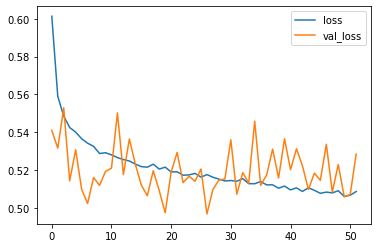

In [133]:
losses = pd.DataFrame(model_dl.history.history)
losses.plot()

In [134]:
predictions_dl = model_dl.predict(X_test)
predictions_dl = [int(round(x[0])) for x in predictions_dl]
print(classification_report(y_test,predictions_dl))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     30588
           1       0.22      1.00      0.36      8460

    accuracy                           0.22     39048
   macro avg       0.11      0.50      0.18     39048
weighted avg       0.05      0.22      0.08     39048



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


we can see that this model requires a lot of improvements

In [118]:
my_submission = pd.DataFrame({'encounter_id': pd.to_numeric(unlabel_raw['encounter_id']).astype(int), 'diabetes_mellitus': predictions_dl})
# you could use any filename. We choose submission here
my_submission.to_csv('predictions_dl2.csv', index=False)